In [1]:
# pre_processing
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer

# selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb

# metrics
from sklearn.metrics import f1_score, plot_roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import scipy
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

# general
import pandas as pd
import numpy as np
from time import time
from Titanic_utils import *
import matplotlib.pyplot as plt
plt.rcParams.update({'text.color' : "k",
                     'axes.labelcolor' : "w",
                     'xtick.color' : "w",
                     'ytick.color' : "w"})

we need to be able to reproduce features from the train to the test,
so we'll create a custom sklean preprocessor transformer object.
[inspiration](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py)

In [2]:
class Preprocessor(BaseEstimator,TransformerMixin):
    """
    A preprocessor transformer class for the Titanic dataset.
    The pre-processing stages are as follows:
    - Use title of names as a feature.
    - Fill NaN ages by the mean age grouped by Title,
        the highest correlating feature.
    - parse deck level from 'Cabin' feature.
    - drop Name, Cabin, Ticket as they were used for another feature,
        or aren't worth the trouble.
    - one-hot categorical data.
    - possibly add/remove columns, based on feature exploration
        and false analysis (added ability to define what columns to drop,
        if they prove to be bad).
    """

    def fit(self, X, *y):
        """
        fit the preprocessor parameters to the training data.
        :param X: data
        :param y: labels
        :return: none (transformer is now fitted).
        """
        X = X.copy()
        X.reset_index(inplace=True,drop=True)
        # create Rare title for titles without enough examples (we consider
        # it to be unknown).
        X['Title'] = X['Name'].apply(lambda x: x.split(',')[1].split()[0])
        self.freq_titles = X['Title'].value_counts()
        self.freq_titles = self.freq_titles[self.freq_titles>4].index
        X.loc[~X['Title'].isin(self.freq_titles),'Title'] = 'Rare'
        self.ages = X.groupby('Title')['Age'].mean()
        splitted_cabin = X['Cabin'].dropna().str.split(pat='[\d ]').apply(lambda x: x[0])
        X['Cabin_Deck'] = pd.DataFrame(splitted_cabin.tolist(), index = splitted_cabin.index)
        if(self.one_hot_cat):
            self.ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
            self.ohe.fit(X[self.cat_columns].fillna(-1).astype(str))
        else:
            # catboost/LightGBM
            X[self.cat_text_cols] = X[self.cat_text_cols].fillna('nan')
            self.ord_enc = OrdinalEncoderWithUnknown()
            self.ord_enc.fit(X[self.cat_text_cols])
        # addition
        X['SibSp^2'] = X['SibSp']**2
        self.scaler = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), ['SibSp^2','Fare','Age'])],remainder='drop')
        self.scaler.fit(X[['SibSp^2','Fare','Age']])

    def add_columns_to_drop(self,cols):
        self.drop_columns.append(cols)

    def remove_columns_to_drop(self,cols):
        self.drop_columns.remove(cols)

    def drop_try(self,df):
        '''
        try to drop columns in 'self.columns_to_drop'.
        if columns doesn't exist - do nothing.
        :param df:
        :return:
        '''
        for col in self.drop_columns:
         try:
             df.drop(col,axis=1,inplace=True)
         except:
             pass
        return df

    def transform(self,X, *y):
        """
        transform the test/cv data to the same format as the train data.
        :param X: data
        :param y: none (unused for preprocessing).
        :return: preprocessed data.
        """
        X = X.copy()
        X.reset_index(inplace=True,drop=True)
        # ticket: just shows family relations, which is covered in parch and sibsp anyway.
        # name: we already extracted titles
        # cabin: we used it for deck feature, no need for it afterwards.
        # one_hot categories all at once, drop originals afterwards.
        # name_to_titles
        X['Title'] = X['Name'].apply(lambda x: x.split(',')[1].split()[0])
        X.loc[~X['Title'].isin(self.freq_titles),'Title'] = 'Rare'
        # fill age NaNs by titles
        # X.Age = self.age_imputer.transform(X.select_dtypes(exclude=object))[:,1]
        X.Age = X.apply(lambda x : self.ages[x['Title']] if np.isnan(x['Age']) else x['Age'],axis=1)
        # cabin_to_deck_no (keep NaNs as is, column is cabin_deck_-1)
        splitted_cabin = X['Cabin'].dropna().str.split(pat='[\d ]').apply(lambda x: x[0])
        X['Cabin_Deck'] = pd.DataFrame(splitted_cabin.tolist(), index = splitted_cabin.index)
        # as sex has only 2 categories, just binarize it.
        X['Sex'] = (X['Sex']=='male').astype(int)
        # found out from feature exploration that sibsp^2 makes a difference.
        X['SibSp^2'] = X['SibSp']**2
        # one_hot categories all at once, drop originals afterwards.
        if(self.one_hot_cat):
            ohe_array = self.ohe.transform(X[self.cat_columns].fillna(-1).astype(str))
            ohe_df = pd.DataFrame(ohe_array, columns=self.ohe.get_feature_names(self.cat_columns))
            X = pd.concat([X,ohe_df],axis='columns').drop(self.cat_columns,axis='columns')
        else:
            X[self.cat_text_cols] = self.ord_enc.transform(X[self.cat_text_cols].fillna('nan')).astype(int)
        X[['SibSp^2','Fare','Age']] = self.scaler.transform(X[['SibSp^2','Fare','Age']])
        X = self.drop_try(X)
        self.features = X.columns
        return X

    def fit_transform(self,X, *y):
        """
        fit the preprocessor parameters to the training data,
        and transform the train data as well (using tranform func)
        :param data:
        X_train data, to fit the data preprocessor transformer.
        :return:
        -------
        X_new : ndarray array of shape (n_samples, n_features_new)
            Transformed array.
        """
        self.fit(X,y)
        return self.transform(X,y)
    def get_features(self):
        return self.features
    def __init__(self,one_hot_cat = True,cols_to_drop = None):
        self.one_hot_cat = one_hot_cat
        self.drop_columns = ['Ticket','Name','Cabin']
        if cols_to_drop is not None :
            self.drop_columns += cols_to_drop
        self.cat_columns = ['Pclass','Title','SibSp','Embarked','Cabin_Deck']
        self.cat_text_cols = ['Title','Embarked','Cabin_Deck']

# data and classifier setup

In [3]:
data = pd.read_csv('titanic.csv')
data.dtypes
X, X_test, y, y_test = train_test_split(data.drop('Survived',axis=1),
                                        data['Survived'], test_size=0.2,
                                        random_state=42)

## Baseline Value
method: just through away everything that isn't numeric,
fill with median (robust to outliers), One_hot categories, done.
taken from [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

In [4]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])
categorical_features = ['Pclass','Sex','SibSp','Parch','Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# note that Col Transformer returns only the transformed columns (unless remainder param set to 'passthrough')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
baseline_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

scores = cross_val_score_regular(baseline_clf,X,y)
print('baseline scores (cv and train): ',*scores,sep='\n')

baseline scores (cv and train): 
[0.80295464 0.77913025 0.77293771 0.71675084 0.79128683]
0.7726120561847719
[0.78336618 0.77082512 0.77566328 0.7901736  0.77581607]
0.7791688508252099


In [5]:
pp = Preprocessor()
pp.fit(X)
pp.transform(X).dtypes

Sex                int32
Age              float64
Parch              int64
Fare             float64
SibSp^2          float64
Pclass_1         float64
Pclass_2         float64
Pclass_3         float64
Title_Dr.        float64
Title_Master.    float64
Title_Miss.      float64
Title_Mr.        float64
Title_Mrs.       float64
Title_Rare       float64
SibSp_0          float64
SibSp_1          float64
SibSp_2          float64
SibSp_3          float64
SibSp_4          float64
SibSp_5          float64
SibSp_8          float64
Embarked_-1      float64
Embarked_C       float64
Embarked_Q       float64
Embarked_S       float64
Cabin_Deck_-1    float64
Cabin_Deck_A     float64
Cabin_Deck_B     float64
Cabin_Deck_C     float64
Cabin_Deck_D     float64
Cabin_Deck_E     float64
Cabin_Deck_F     float64
Cabin_Deck_G     float64
Cabin_Deck_T     float64
dtype: object

In [6]:
# general structure of pipeline:
from sklearn import set_config
set_config(display='diagram')
baseline_clf
set_config(display='text')

## catboost and lightgbm
 they can handle categorical data, so we'll start off with them, as they need a special setup.

In [7]:
cb_clf = CatBoostClassifier(iterations=100,
                            task_type="GPU",
                            devices='0=1',
                            cat_features=['Pclass','Title','SibSp',
                                          'Parch','Embarked','Cabin_Deck'],
                            verbose=False)
cb = False
if(cb):
    pipe = Pipeline([('pre_processing',Preprocessor(one_hot_cat=False)),('classifier',cb_clf)])
    cv_scores = cross_val_score_regular(pipe,X,y)
    print('catboost cv and train scores: ',*cv_scores,sep='\n')
else:
    lgb_params = {'classifier__categorical_feature':['Pclass','Title','SibSp','Parch','Embarked','Cabin_Deck']}
    lgb_clf = lgb.sklearn.LGBMClassifier()
    pipe = Pipeline([('pre_processing',Preprocessor(one_hot_cat=False)),('classifier',lgb_clf)])
    pipe.fit(X,y)
    cv_scores = cross_val_score_regular(pipe,X,y)
    print(*cv_scores,sep='\n')

[0.77517686 0.8363504  0.80639731 0.78787879 0.78927284]
0.7990152389558791
[0.96129287 0.94410064 0.94546348 0.95018015 0.94985876]
0.9501791791347216


## fitting classifiers with hyper-parameters

setting up classifiers and their parameters:

In [30]:
names = ["Logistic_Regression",
         "Linear_SVM", "RBF_SVM",
         "Decision_Tree",
         "Neural_Net", "AdaBoost",
         "Random_Forest","XGBoost"]
param_grid = {'Logistic_Regression':
                  {'classifier__C':loguniform(1e-3, 1e3),
                   'classifier__penalty':['l1','l2']},
              'Linear_SVM':
                  {'classifier__C': scipy.stats.expon(scale=100),
                    'classifier__gamma': scipy.stats.expon(scale=.1),
                    'classifier__kernel': ['rbf'],
                    'classifier__class_weight':['balanced', None]},
              'RBF_SVM':
                  {'classifier__C': loguniform(1e0, 1e3),
                    'classifier__gamma': loguniform(1e-4, 1e-3),
                    'classifier__kernel': ['rbf']},
              'Decision_Tree':
                  {"classifier__max_depth": np.linspace(2,10,5),
                     "classifier__max_features": range(1,9),
                     "classifier__min_samples_leaf": range(3,9),
                     "classifier__criterion": ["gini", "entropy"]},
              'Neural_Net':{
                  'classifier__solver': ['lbfgs','adam'],
                  'classifier__max_iter': [500,1000,1500],
                  'classifier__alpha': 10.0 ** -np.arange(1, 7),
                  'classifier__hidden_layer_sizes':np.arange(5, 12)
              },
              'AdaBoost':{
                  'classifier__n_estimators': [100,200,500],
                  'classifier__learning_rate' : loguniform(1e-2, 1e0),
                  'classifier__base_estimator__max_depth' : [4,5,6,7,8]
              },
              'Random_Forest':{
                  'classifier__n_estimators': [200, 500],
                  'classifier__max_features': ['auto', 'sqrt', 'log2'],
                  'classifier__max_depth' : [4,5,6,7,8],
                  'classifier__criterion' :['gini', 'entropy']},
              'XGBoost':{
                  'classifier__learning_rate':loguniform(1e-2, 1e0),
                  'classifier__gamma':[0,1,5],
                  'classifier__n_estimators': [500,750,1000],
                  'classifier__max_depth': [3,6,8],
                  'classifier__subsample': uniform(loc=0.8,scale=0.2),
                  'classifier__colsample_bytree': uniform(loc=0.8,scale=0.2)
              }}
classifiers = [
    LogisticRegression(C=0.3,n_jobs=-1,solver='newton-cg'),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(hidden_layer_sizes=(5,3),alpha=1, max_iter=1000),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),n_estimators=500),
    RandomForestClassifier(max_depth=9, n_estimators=400, max_features=1),
    xgb.XGBClassifier(max_depth=10,learning_rate =0.3,n_estimators=500,
                      objective="reg:squarederror", n_jobs = -1,random_state=42),
]

## Random Search on each Clf (20 rounds)

In [31]:
scores = []
random_searches = {}
for (name,clf) in zip(names, classifiers):
    pipeclf = Pipeline([('pre_processing',Preprocessor()),('classifier',clf)])
    print(name)
    n_iter_search = 20
    random_searches[name] = RandomizedSearchCV(pipeclf,param_grid[name],
                                               n_jobs=-1,scoring='roc_auc',
                                               n_iter=n_iter_search,
                                               return_train_score=True)
    start = time()
    random_search = random_searches[name]
    random_search.fit(X, y)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), n_iter_search))
    print(random_search.best_estimator_,'\nauc: ',random_search.best_score_)
    scores.append((name,random_search.best_score_))

Logistic_Regression
RandomizedSearchCV took 6.26 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 LogisticRegression(C=0.1318719509629811, n_jobs=-1,
                                    solver='newton-cg'))]) 
auc:  0.8631437734350073
Linear_SVM
RandomizedSearchCV took 3.87 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 SVC(C=81.2711365156844, gamma=0.00911830611703852))]) 
auc:  0.8663099843391873
RBF_SVM
RandomizedSearchCV took 3.64 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 SVC(C=4.097807229697087, gamma=0.000928771165291882))]) 
auc:  0.8576514428790769
Decision_Tree
RandomizedSearchCV took 3.33 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor(

C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local

# False analysis

In [10]:
# save searches.
from joblib import dump, load
dump(random_searches, 'random_searches.joblib')

['random_searches.joblib']

In [11]:
random_searches = load('random_searches.joblib')

see scores of the best classifiers.

In [12]:
random_searches_list = list(random_searches.items())
random_searches_list.sort(key=lambda x:x[1].best_score_,reverse=True)
for (name,rand_search) in random_searches_list[:3]:
    print(name,'\n')
    print('best index: ',rand_search.best_index_)
    for metric in rand_search.cv_results_.items():
        print(metric[0],metric[1][rand_search.best_index_])
    print('\n\n')

Random_Forest 

best index:  11
mean_fit_time 0.6774003505706787
std_fit_time 0.05313293414715978
mean_score_time 0.07860193252563477
std_score_time 0.003615692523707627
param_classifier__n_estimators 200
param_classifier__max_features log2
param_classifier__max_depth 5
param_classifier__criterion gini
params {'classifier__n_estimators': 200, 'classifier__max_features': 'log2', 'classifier__max_depth': 5, 'classifier__criterion': 'gini'}
split0_test_score 0.8244902205576363
split1_test_score 0.908239700374532
split2_test_score 0.8195496632996633
split3_test_score 0.8453282828282829
split4_test_score 0.9103243587025652
mean_test_score 0.8615864451525359
std_test_score 0.039898519245510446
rank_test_score 1
split0_train_score 0.9190185258178951
split1_train_score 0.8959926422283537
split2_train_score 0.9200458565345562
split3_train_score 0.9127481166066165
split4_train_score 0.9032093534212179
mean_train_score 0.9102028989217279
std_train_score 0.009294281028278837



XGBoost 

best inde

In [13]:
best_clf = random_searches_list[0][1].best_estimator_
cols = best_clf['pre_processing'].fit_transform(X).columns
importances = best_clf['classifier'].feature_importances_
df = pd.DataFrame(np.c_[cols,importances],columns=['Columns','Importances'])
print(df)
# print(list(df[df['Importances']==0]['Columns']))

          Columns  Importances
0             Sex     0.216024
1             Age    0.0589352
2           Parch    0.0217924
3            Fare    0.0831595
4         SibSp^2    0.0292305
5        Pclass_1    0.0374797
6        Pclass_2    0.0156107
7        Pclass_3    0.0711937
8       Title_Dr.   0.00118853
9   Title_Master.   0.00813247
10    Title_Miss.    0.0460607
11      Title_Mr.      0.17295
12     Title_Mrs.    0.0730131
13     Title_Rare   0.00280771
14        SibSp_0    0.0098823
15        SibSp_1    0.0108997
16        SibSp_2   0.00206973
17        SibSp_3   0.00332359
18        SibSp_4   0.00507819
19        SibSp_5  0.000460626
20        SibSp_8   0.00177538
21    Embarked_-1  0.000295817
22     Embarked_C    0.0129451
23     Embarked_Q   0.00657096
24     Embarked_S    0.0160002
25  Cabin_Deck_-1    0.0483409
26   Cabin_Deck_A   0.00122112
27   Cabin_Deck_B    0.0120657
28   Cabin_Deck_C   0.00460266
29   Cabin_Deck_D   0.00474501
30   Cabin_Deck_E    0.0179908
31   Cab

In [14]:
feature_importances,fp,fn = get_errors_and_features(best_clf,X,y)
feature_importances

[[78 11]
 [16 38]]
fp: 
      Pclass                                               Name     Sex   Age  \
5         1                           Baxter, Mr. Quigg Edmond    male  24.0   
7         2              Lahtinen, Mrs. William (Anna Sylfven)  female  26.0   
35        1                          Brewe, Dr. Arthur Jackson    male   NaN   
42        2             Yrois, Miss. Henriette ("Mrs Harbeck")  female  24.0   
52        3                                Canavan, Miss. Mary  female  21.0   
77        3  Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...  female  30.0   
81        1                                  Gee, Mr. Arthur H    male  47.0   
114       3                      Boulos, Mrs. Joseph (Sultana)  female   NaN   
116       1                            McCarthy, Mr. Timothy J    male  54.0   
128       3     Robins, Mrs. Alexander A (Grace Charity Laury)  female  47.0   
132       2  Turpin, Mrs. William John Robert (Dorothy Ann ...  female  27.0   

     SibSp  Pa

array([[0.14755806634662205, 'Sex'],
       [0.054520121208982, 'Age'],
       [0.01926529942775782, 'Parch'],
       [0.09669259658281129, 'Fare'],
       [0.023285527933935637, 'SibSp^2'],
       [0.03577670381768676, 'Pclass_1'],
       [0.014822962446949972, 'Pclass_2'],
       [0.06584107406321463, 'Pclass_3'],
       [0.0016187892633401618, 'Title_Dr.'],
       [0.007374335412958011, 'Title_Master.'],
       [0.04150188453860577, 'Title_Miss.'],
       [0.23614407457902742, 'Title_Mr.'],
       [0.06995454139538816, 'Title_Mrs.'],
       [0.00435238873656921, 'Title_Rare'],
       [0.009894907287983536, 'SibSp_0'],
       [0.011574103118654047, 'SibSp_1'],
       [0.0018677484527196986, 'SibSp_2'],
       [0.002033644708053833, 'SibSp_3'],
       [0.0038503549500693386, 'SibSp_4'],
       [0.0017320803091352174, 'SibSp_5'],
       [0.002278571831794835, 'SibSp_8'],
       [1.9713965384735713e-05, 'Embarked_-1'],
       [0.018313178594373498, 'Embarked_C'],
       [0.0059840966425

We see that most misclassifications are fn.
let's take a closer look:

In [15]:
best_clf['pre_processing'].transform(fn)['Title_Mr.']

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     0.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
Name: Title_Mr., dtype: float64

we see that almost all fn's are men ('Mr.' to be specific). In addition,
we see that the classifier puts a large emphasis on both title and one's Sex.\
Since we can assume the Titles cover one's sex (a 'Mrs.' is a female, etc),\
we'll try to remove the Sex, as it has a high correlation with the titles.
to prove this, we'll check it's chi2 score with "Mr.":

In [16]:
trans_x = best_clf['pre_processing'].transform(X)
chi2(trans_x['Title_Mr.'].to_frame(),trans_x['Sex'])

(array([218.97435897]), array([1.51392505e-49]))

voalá. Insane score. let's try the same thing without Sex (as the titles
are more precise than Sex):

In [17]:
trans_x_no_sex = trans_x.drop('Sex',axis=1)
print('original score, with sex:\n',
      *cross_val_score_regular(best_clf['classifier'],trans_x,y),sep='\n')
print('\n\n"improved" score, without sex:\n',
      *cross_val_score_regular(best_clf['classifier'],trans_x_no_sex,y),sep='\n')

original score, with sex:

[0.78277154 0.82740325 0.77651515 0.77651515 0.81937672]
0.7965163614093018
[0.84990803 0.84716857 0.84471012 0.84294137 0.84110169]
0.8451659569822032


"improved" score, without sex:

[0.76425302 0.80690803 0.76578283 0.77861953 0.7758109 ]
0.7782748604695817
[0.8662725  0.83786625 0.84575827 0.83137897 0.84031701]
0.8443186001070438


aaaaaand it didn't work :(
let's try removing the columns that aren't relevant to the model (i.e. got feature_importance 0):

In [18]:
cols_to_drop = [x[1] for x in feature_importances if x[0]==0]
print('old pipe',*cross_val_score_regular(best_clf,X,y),sep='\n')
pipe_filtered = Pipeline([('pre_processing',Preprocessor(cols_to_drop=cols_to_drop)),
                    ('classifier', best_clf['classifier'])])
print('new pipe',*cross_val_score_regular(pipe_filtered,X,y),sep='\n')

old pipe
[0.78641282 0.82178527 0.78219697 0.76725589 0.83442866]
0.7984159219928777
[0.84617002 0.83736697 0.85774648 0.85322633 0.85318581]
0.8495391224997835
new pipe
[0.77153558 0.82178527 0.78219697 0.76157407 0.83241467]
0.7939013126102378
[0.84384444 0.83919327 0.85217819 0.84808385 0.85601067]
0.8478620835217292


In [19]:
np.c_[pipe_filtered['classifier'].feature_importances_,
      pipe_filtered['pre_processing'].get_features()]

array([[0.17879910823422437, 'Sex'],
       [0.05689529780776213, 'Age'],
       [0.023730730586101693, 'Parch'],
       [0.10213345479714955, 'Fare'],
       [0.040831900257978615, 'SibSp^2'],
       [0.05026902389167042, 'Pclass_1'],
       [0.0113876467981609, 'Pclass_2'],
       [0.07178393929387732, 'Pclass_3'],
       [0.0028159169632435265, 'Title_Dr.'],
       [0.0108817406837449, 'Title_Master.'],
       [0.03178228369341245, 'Title_Miss.'],
       [0.17918718295502226, 'Title_Mr.'],
       [0.07477866948595278, 'Title_Mrs.'],
       [0.002479239015436822, 'Title_Rare'],
       [0.011263774077739543, 'SibSp_0'],
       [0.010522134433402682, 'SibSp_1'],
       [0.002919992656201411, 'SibSp_2'],
       [0.004238448664272785, 'SibSp_3'],
       [0.004075187040135072, 'SibSp_4'],
       [0.0004097854450713333, 'SibSp_5'],
       [0.002705062213589189, 'SibSp_8'],
       [0.00030767549575094625, 'Embarked_-1'],
       [0.014344443860830836, 'Embarked_C'],
       [0.003908796629588

in addition, let's try creating the clf again, but incorporating the skewness of the class.
scale_pos_weight=negatives/positives.

In [20]:
xgb_params = pipe_filtered['classifier'].get_params()
xgb_params['scale_pos_weight'] = ((y==1).sum()/(y==0).sum()) # positive cases/neg cases.
xgb_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'scale_pos_weight': 0.6072234762979684}

In [21]:
old_clf = best_clf['classifier']
skew_pipe = Pipeline([('pre_processing',pipe_filtered['pre_processing']),
                    ('classifier', xgb.XGBClassifier(**xgb_params))])
print('filtered pipe:',*cross_val_score_regular(pipe_filtered,X,y),sep='\n')
print('skewed pipe',*cross_val_score_regular(skew_pipe,X,y),sep='\n')

filtered pipe:
[0.78277154 0.82178527 0.78787879 0.77293771 0.83442866]
0.799960392919371
[0.84990803 0.83686769 0.85879463 0.8550606  0.84561362]
0.8492489131639426
[17:03:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { bootstrap, ccp_alpha, criterion, max_features, min_impurity_decrease, min_samples_leaf, min_samples_split, min_weight_fraction_leaf, oob_score, verbose, warm_start } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:03:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { bootstrap, ccp_alpha, criterion, max_features, min_impurity_decrease, min_samples_leaf, min_samples_split, min_weight_fraction_leaf, oob_score, verbose, warm_start } might not b

didn't work. reverting back to filtered pipe.
finally, we should try dealing with the fact that the data is skewed
by stratifying the initial split maybe:

In [22]:
X_strat,X_test_strat,y_strat,y_test_strat = train_test_split(data.drop('Survived',axis=1),
                                        data['Survived'], test_size=0.2,
                                        random_state=42,stratify=data['Survived'])

In [23]:
cross_val_score_regular(pipe_filtered,X_strat,y_strat)

(array([0.84204545, 0.80795455, 0.81859979, 0.79707419, 0.79503367]),
 0.8121415302449785,
 array([0.83928898, 0.85269406, 0.85509113, 0.84283651, 0.85090909]),
 0.8481639547666944)

We didn't change the model, only now we're looking at a more realistic test case.
now, it seems we overfit the training set. we need to reduce the expressibility of the model.
let's reduce the dimension of the model, by further removing features below a certain
threshold:

In [24]:
cols_to_drop_2 = [x[1] for x in np.c_[pipe_filtered['classifier'].feature_importances_,
                                   pipe_filtered['pre_processing'].get_features()] if x[0]<0.01]
pipe_filtered_2 = Pipeline([('pre_processing',Preprocessor(cols_to_drop=cols_to_drop+cols_to_drop_2)),
                    ('classifier', best_clf['classifier'])])
pipe_filtered_2
print('filtered_pipe_1',*cross_val_score_regular(pipe_filtered,X,y),sep='\n')
print('pipe_filtered_2',*cross_val_score_regular(pipe_filtered_2,X,y),sep='\n')

filtered_pipe_1
[0.77351228 0.83104453 0.78219697 0.76157407 0.82117872]
0.7939013126102378
[0.8484956  0.84243201 0.84611857 0.85132656 0.8606403 ]
0.8498026084065378
pipe_filtered_2
[0.78838951 0.82178527 0.78219697 0.77861953 0.81937672]
0.798073600466541
[0.84990803 0.84384444 0.85640354 0.85316083 0.84290647]
0.8492446584498303


I guess good enough for now.
### visualize roc_auc score
taken from [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html)

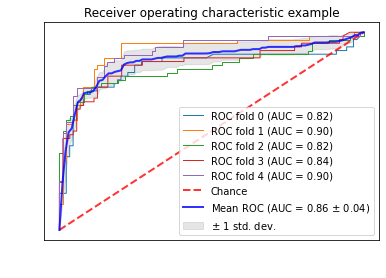

In [25]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
kf = StratifiedKFold()
lr_clf_pipe = pipe_filtered_2
for i, (train, test) in enumerate(kf.split(X, y)):
    lr_clf_pipe.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(lr_clf_pipe, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


# the final test

In [26]:
# final test
best_clf = pipe_filtered_2
best_clf.fit(X,y)
pred = best_clf.predict(X_test)
print('score: ',roc_auc_score(y_test,pred))
print(confusion_matrix(y_test,pred))
print('fp: \n', X_test[(y_test != pred) & (y_test == 0)])
fn = X_test[(y_test != pred) & (y_test == 1)]
print('\n\nfn: \n', fn)

score:  0.8264187866927593
[[93 12]
 [17 56]]
fp: 
      Pclass                                           Name     Sex   Age  \
854       2  Carter, Mrs. Ernest Courtenay (Lilian Hughes)  female  44.0   
396       3                            Olsson, Miss. Elina  female  31.0   
235       3                   Harknett, Miss. Alice Phoebe  female   NaN   
578       3               Caram, Mrs. Joseph (Maria Elias)  female   NaN   
593       3                             Bourke, Miss. Mary  female   NaN   
852       3                        Boulos, Miss. Nourelain  female   9.0   
807       3                Pettersson, Miss. Ellen Natalia  female  18.0   
49        3  Arnold-Franchi, Mrs. Josef (Josefine Franchi)  female  18.0   
254       3       Rosblom, Mrs. Viktor (Helena Wilhelmina)  female  41.0   
745       1                   Crosby, Capt. Edward Gifford    male  70.0   
362       3                Barbara, Mrs. (Catherine David)  female  45.0   
772       2                         

In [27]:
X_test.dtypes
# X.iloc[0,:]

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [32]:
newbie = [1,'Shumacher, Mr. Ariel','male',21,2,4,None,30,'E3','S']
def get_df_like_titanic(x):
    res = X.iloc[0:0,:].copy()
    res.append(x)
    return res
def will_you_survive(*params):
    res = X.iloc[0:0,:].copy()
    df = pd.DataFrame(np.atleast_2d(params),columns=X.columns)
    for x in X.columns:
        df[x]=df[x].astype(X[x].dtypes.name)
    print(df,'\n',df.dtypes)
    print('will you survive?: ',best_clf.predict(df)==1,
          '\nwith probability:',best_clf.predict_proba(df))
will_you_survive(*newbie)

   Pclass                  Name   Sex   Age  SibSp  Parch Ticket  Fare Cabin  \
0       1  Shumacher, Mr. Ariel  male  21.0      2      4   None  30.0    E3   

  Embarked  
0        S   
 Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object
will you survive?:  [ True] 
with probability: [[0.49839963 0.50160037]]
